In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

### Week 4: NLP with Disaster Tweets

#### Problem
This project will be looking at various Tweets from the social media platform Twitter/X, and building a Natural Language Processing Model to identify whether a tweet is indicating a disaster occurence or not. This project will use data from https://www.kaggle.com/c/nlp-getting-started/overview, using training data labeled with text, keywords, location, and whether or not it's a real disaster or not.

#### EDA
First starting out by importing the CSVs and taking a look at the training data. I'll import all columns as strings so I don't need to convert them later.

In [46]:
train_df = pd.read_csv('nlp-getting-started/train.csv', dtype=str)
test_df = pd.read_csv('nlp-getting-started/test.csv', dtype=str)
submit_df = pd.read_csv('nlp-getting-started/sample_submission.csv', dtype=str)

print(train_df.info())
print("Columns: ", train_df.columns)
print("Training data shape: ", train_df.shape)
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   object
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   object
dtypes: object(5)
memory usage: 297.5+ KB
None
Columns:  Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')
Training data shape:  (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Looking at the data from train_df.info(), there's 7613 total entries with 5 columns in the data set, but 2533 of them are missing location data, and 61 of them are missing keywords. 

Looking at the test data, missing location/keyword data is a regular occurence, so I'll likely want to keep entries with missing info during training still, but I'll fill in the null values with the empty string '' so it doesn't cause issues later.

In [70]:
train_df.fillna('')
test_df.fillna('')
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   object
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: object(4)
memory usage: 102.1+ KB
None


I also want to check the balance of the data to see if it's heavily skewed towards either label. Looking at the graph, there's about a 1000 more 0s than 1s, but it's not overly imbalanced, so I'll keep it as is.

target
0    4342
1    3271
Name: count, dtype: int64


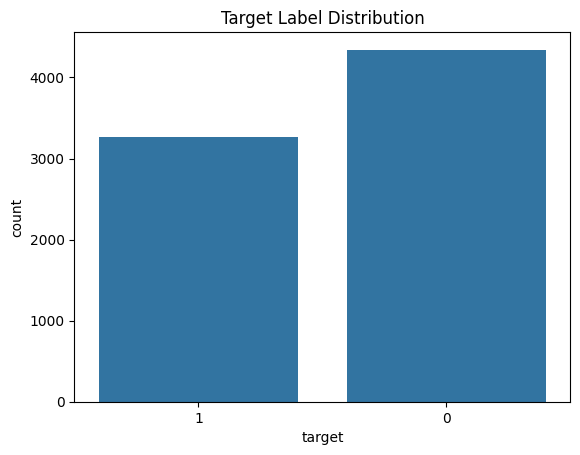

In [48]:
print(train_df['target'].value_counts())
sns.countplot(x='target', data=train_df)
plt.title('Target Label Distribution')
plt.show()

We need to preprocess the text a bit before feeding to the model. I'll be cleaning up the text column by removing punctuation, stop words, and tokenizing the text.

In [71]:
# Preprocessing text
import spacy

nlp = spacy.load("en_core_web_sm")

def text_preprocess(text):
    # Lower casing
    doc = nlp(text.lower())

    # Removing Punctuation, Stop words, and Tokenizing
    tokens = [token.lemma_ for token in doc if (not token.is_stop and not token.is_punct and not token.is_digit)] 

    return ' '.join(tokens)

# Do I actually want to remove stop words?
train_df['text'] = train_df['text'].apply(text_preprocess)
test_df['text'] = test_df['text'].apply(text_preprocess)

# train_df['keyword'] = train_df['keyword'].apply(text_preprocess)
# test_df['keyword'] = test_df['keyword'].apply(text_preprocess)

print("Clean text example: " + train_df['text'][0])

Clean text example: deed reason earthquake allah forgive


I want to get an idea of what the text looks like now, so I'll take a look at the text length and the number of unique words.

In [72]:
from collections import Counter

def count_words(text):
    count = Counter()
    for t in text.values:
        for word in t.split():
            count[word] += 1
    return count

unique_word_count = len(count_words(train_df.text))
print("Unique Word Count: ", unique_word_count)

text_length = train_df['text'].str.len()
text_length.describe()


Unique Word Count:  19671


count    7613.000000
mean       72.762249
std        29.189830
min         3.000000
25%        51.000000
50%        74.000000
75%        95.000000
max       156.000000
Name: text, dtype: float64

We also need to split the training data into training and validation sets. I'll split 0/1 individually so there's an even distribution of 0/1s in the test and validation set.

In [73]:
# Splitting sets
from sklearn.model_selection import train_test_split

zeros = train_df[train_df['target'] == "0"]
ones = train_df[train_df['target'] == "1"]

train0, val0 = train_test_split(zeros, test_size=0.3, random_state=10)
train1, val1 = train_test_split(ones, test_size=0.3, random_state=10)

train_set = pd.concat([train0, train1])
val_set = pd.concat([val0, val1])

X_train = train_set.text
y_train = train_set.target

train_set.head()

,id,keyword,location,text,target
3846,5473,flames,NaN,sbnation flame good penalty killer http://t.co...,0
3136,4507,emergency,New York,survival kit whistle fire starter wire cree to...,0
6186,8831,sirens,"Los Angles, CA",hollywood abc7eyewitness @abc7 helicopter sire...,0
1945,2796,curfew,NaN,hour late curfew pray dog bark unlock door,0
1555,2245,chemical%20emergency,"Jersey City, NJ",@laevantine fortunately rework plumbing emerge...,0


#### Model Architecture

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. 

Since we did not learn NLP-specific techniques such as word embeddings in the lectures, we recommend looking at Kaggle tutorials, discussion boards, and code examples posted for this challenge.  You can use any resources needed, but make sure you “demonstrate” you understood by including explanations in your own words. Also importantly, please have a reference list at the end of the report.  

There are many methods to process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a strategy and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words.

Build and train your sequential neural network model (You may use any RNN family neural network, including advanced architectures LSTM, GRU, bidirectional RNN, etc.). 

In [76]:
# Creating basic architecture
# EMBEDDING_DIM = 128
MAX_LEN = 20

def basic_RNN():
    model = Sequential([
        Embedding(unique_word_count, 128), #, input_length=MAX_LEN  #deprecated?
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.5),
        Bidirectional(LSTM(32)),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

basic_model = basic_RNN()
basic_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Next we'll compile the model. I'll use the Adam optimizer since it'll handle some of the learning rate balancing, and I'll use binary cross-entropy for the loss function.

In [77]:
LEARN_RATE = 0.001

optimizer = Adam(LEARN_RATE)

basic_model.compile(loss='binary_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

In [78]:
BATCH_SIZE = 64
EPOCHS = 10

history1 = basic_model.fit(train_set, 
                epochs=EPOCHS, 
                batch_size=BATCH_SIZE, 
                validation_data=val_set)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

#### Results and Analysis
Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

#### Conclusion
Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?